In [1]:
%load_ext autoreload
%autoreload 2

# Information maximiser

Using neural networks, sufficient statistics can be obtained from data by maximising the Fisher information.

When using this code please cite <a href="https://arxiv.org/abs/1802.03537">arXiv:1802.03537</a>.<br><br>
The code in the paper can be downloaded as v1 or v1.1 of the code kept on zenodo:<br><br>
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1175196.svg)](https://doi.org/10.5281/zenodo.1175196)
<br>
The code presented below is version two (and is much more powerful).

This code is run using<br>
>`python-3.6.1`

>`jupyter-1.0.0`

>`tensorflow-1.8.0`

>`numpy-1.14.2`

>`tqdm==4.19.9`

>`sys (native)`

Although these precise versions may not be necessary, I have put them here to avoid possible conflicts. For reference, all code is run on a nVidia GeForce GTX 1080Ti (OC Strix).

## Load modules

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IMNN

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Generate data
Here were going to use a 2D field of Gaussian noise with zero mean and unknown variance to see if the network can learn to summarise this variance.<br><br>
We start by defining a function to generate the data with the correct shape. This should be 
```
data_shape = None + input shape
```
It is useful to define this function so that it only takes in the value of the parameter as its input since the function can then be used for ABC later.<br><br>
The data needs to be generated at a fiducial parameter value and at perturbed values just below and above the fiducial parameter for the numerical derivative. The data at the perturbed values should have the shape
```
perturbed_data_shape = None + number of parameters + input shape
```

We will choose the input shape to be a 10x20 pixel image with one channel.

In [3]:
input_shape = [10, 20, 1]

In [4]:
def generate_data(θ, train = False):
    if train:
        return np.moveaxis(np.random.normal(0., np.sqrt(θ), [1] + input_shape + [len(θ)]), -1, 0)
    else:
        return np.moveaxis(np.random.normal(0., np.sqrt(θ), input_shape + [len(θ)]), -1, 0)

### Training data
Enough data needs to be made to approximate the covariance matrix of the output summaries. If the data is particularly large then several combinations need to be used (although this will lead to a less well approximated covariance matrix). We choose the number of simulations for each single combination to be 1000, and we will use all the data at once.

In [5]:
n_s = 1000
n_train = 1

The fiducial parameter data can now be created, with variance θ = 1. We define how many simulations to use by passing the fiducial parameter through as a list. This is very useful for the ABC function later.

In [6]:
t = generate_data(θ = [1. for i in range(n_train * n_s)], train = False)

A numerical derivative is used to calculate the derivative of the mean. This means we need to create simulations at values slightly above and below the central fiducial parameter value. By suppressing the sample variance between the simulations created at the lower and upper parameter values far fewer simulations are needed. We choose to use 5% of the total number of simulations.

In [7]:
derivative_fraction = 0.05
n_p = int(n_s * derivative_fraction)

The sample variance can be supressed by choosing the same initial seed when creating the upper and lower simulations.

In [8]:
seed = np.random.randint(1e6)
np.random.seed(seed)
t_m = generate_data(θ = [0.9 for i in range(n_train * n_p)], train = True)
np.random.seed(seed)
t_p = generate_data(θ = [1.1 for i in range(n_train * n_p)], train = True)
np.random.seed()

We also need to get the denominator of the derivative which is given by the difference between the perturbed parameter values<br><br>
$$\frac{\partial}{\partial\theta} = \frac{1}{1.1 - 0.9}.$$<br>
This needs to be done for every parameter and kept in a numpy array.

In [9]:
derivative_denominator = 1. / 0.2
der_den = np.array([derivative_denominator])

We will pass the data to the GPU in one go using a dictionary.

In [10]:
data = {"x_central": t, "x_m": t_m, "x_p":t_p}
train_data = [t, t_m, t_p]

### Test data
We should also make some test data, although we don't need multiple combinations of this, i.e. `n_train = 1`.

In [11]:
tt = generate_data([1. for i in range(n_s)])
seed = np.random.randint(1e6)
np.random.seed(seed)
tt_m = generate_data([0.9 for i in range(n_p)], train = True)
np.random.seed(seed)
tt_p = generate_data([1.1 for i in range(n_p)], train = True)
np.random.seed()
data["x_central_test"] = tt
data["x_m_test"] = tt_m
data["x_p_test"] = tt_p
test_data = [tt, tt_m, tt_p]

### Data visualisation
We can simply plot a projection of some of the data to see what it looks like.

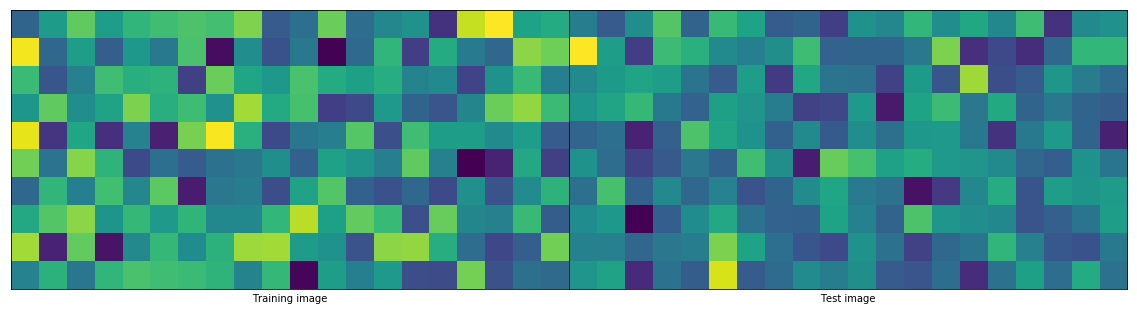

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (20, 12))
plt.subplots_adjust(wspace = 0)
ax[0].imshow(data["x_central"][np.random.randint(n_train * n_s), :, :, 0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('Training image')
ax[1].imshow(data["x_central_test"][np.random.randint(n_s), :, :, 0])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('Test image');

## Initiliase the neural network
### Define network parameters
The network works with a base set of parameters which are<br>
> `'verbose'` - `bool` - whether to print out diagnostics

> `'number of simulations'` - `int` - the number of simulations to use in any one combination

> `'number of combinations'` - `int` - the number of combinations to split simulations into

> `'differentiation fraction'` - `float` - a fraction of the simulations to use for the numerical derivative

> `'number of parameters'` - `int` - number of parameters in a model

> `'number of summaries'` - `int` - number of summaries the network makes from the data

> `'input shape'` - `int` or `list` - the number of inputs or the shape of the input if image-like input

> `'preload data'` - `dict` or `None` - the training (and test) data to preload to the GPU in a ditionary, no preloading is done if `None`

> `'prebuild'` - `bool` - whether to get the network to build a network or to provided your own

> `'save file'` - `string` - a file name to save the graph (not saved if wrong type or not given)

```python
parameters = {
    'verbose': True,
    'number of simulations': n_s,
    'number of combinations': n_train,
    'differentiation fraction': derivative_fraction,
    'number of parameters': 1,
    'number of summaries': 1,
    'input shape': input_shape,
    'preload data': data,
    'prebuild': False,
}
```
The module can also build simple convolutional or dense networks (or a mixture of the two), which can be trigger by setting `'prebuild': True`. Several parameters are required to allow the network to build the network. These are<br>
> `'wv'` - `float` - the variance with which to initialise the weights. If this is 0 or less, the network will determine the weight variance

> `'bb'` - `float` - the constant value with which to initialise the biases

> `'activation'` - `TensorFlow function` - a native tensorflow activation function

> `'α'` - `float` or `int` - an additional parameter, if needed, for the tensorflow activation function

> `'hidden layers'` - `list` - the architecture of the network. each element of the list is a hidden layer. A dense layer can be made using an integer where thet value indicates the number of neurons. A convolutional layer can be built by using a list where the first element is an integer where the number describes the number of filters, the second element is a list of the kernel size in the x and y directions, the third elemnet is a list of the strides in the x and y directions and the final element is string of 'SAME' or 'VALID' which describes the padding prescription.

Here is an example of the IMNN which uses 1000 simulations per combination and 100 simulations per derivative for a model with one parameter where we require one summary. The module will build the network which takes in an input image of shape `[10, 20, 1]` and allows the network to decide the weight initialisation, initialises the biases at `bb = 0.1` and uses `tf.nn.leaky_relu` activation with a negative gradient parameter of `α = 0.01`. The network architecture is a convolution with 10 filters and a 5$\times$5 kernel which does 2$\times$2 strides, with 0-padding, followed by another convolution with 6 filters and 3$\times$3 kernel with no striding and 0-padding. This is then followed by two dense layers with 100 neurons in each. We will save the graph into a file in the `data` folder called `saved_model.meta`.

In [13]:
'''
parameters = {
    'verbose': True,
    'number of simulations': n_s,
    'number of parameters': 1,
    'differentiation fraction': derivative_fraction,
    'number of summaries': 1,
    'prebuild': True,
    'input shape': input_shape,
    'preload data': None,
    'wv': 0.,
    'bb': 0.1,
    'activation': tf.nn.leaky_relu,
    'α': 0.01,
    'hidden layers': [[10, [5, 5], [2, 2], 'SAME'], [6, [3, 3], [1, 1], 'SAME'], 100, 100],
}
'''
parameters = {
    'verbose': True,
    'number of simulations': n_s,
    'number of combinations': n_train,
    'number of parameters': 1,
    'differentiation fraction': derivative_fraction,
    'number of summaries': 1,
    'prebuild': True,
    'input shape': input_shape,
    'preload data': data,
    'wv': 0.,
    'bb': 0.1,
    'activation': tf.nn.leaky_relu,
    'α': 0.01,
    'hidden layers': [[10, [5, 5], [2, 2], 'SAME'], [6, [3, 3], [1, 1], 'SAME'], 100, 100],
}

All the network parameters are initialised using

In [14]:
n = IMNN.IMNN(parameters = parameters)

model not being saved
network architecture is [[10, 20, 1], [10, [5, 5], [2, 2], 'SAME'], [6, [3, 3], [1, 1], 'SAME'], 100, 100, 1].


### Build the network
To build the network a learning rate, η, must be defined. The `setup(η)` function initialises the input tensors, builds the network and defines the optimisation scheme.

In [15]:
n.setup(η = 1e-4, network = None)

Tensor("StopGradient:0", shape=(?, 10, 20, 1), dtype=float32)
Tensor("IMNN/layer_1/conv_1/mul:0", shape=(?, 5, 10, 10), dtype=float32)
Tensor("IMNN/layer_2/conv_2/mul:0", shape=(?, 5, 10, 6), dtype=float32)
Tensor("IMNN/layer_3/dense_3/mul:0", shape=(?, 100), dtype=float32)
Tensor("IMNN/layer_4/dense_4/mul:0", shape=(?, 100), dtype=float32)
Tensor("IMNN/layer_5/LeakyRelu:0", shape=(?, 1), dtype=float32)
Tensor("output:0", shape=(?, 1), dtype=float32)
Tensor("stack:0", shape=(1000, 10, 20, 1), dtype=float32)
Tensor("IMNN_1/layer_1/conv_1/mul:0", shape=(1000, 5, 10, 10), dtype=float32)
Tensor("IMNN_1/layer_2/conv_2/mul:0", shape=(1000, 5, 10, 6), dtype=float32)
Tensor("IMNN_1/layer_3/dense_3/mul:0", shape=(1000, 100), dtype=float32)
Tensor("IMNN_1/layer_4/dense_4/mul:0", shape=(1000, 100), dtype=float32)
Tensor("IMNN_1/layer_5/LeakyRelu:0", shape=(1000, 1), dtype=float32)
Tensor("Const_3:0", shape=(1000, 10, 20, 1), dtype=float32)
Tensor("IMNN_1/layer_1_1/LeakyRelu:0", shape=(1000, 5, 10

### Self-defined network
A self defined network can be used instead of letting the module build the network for you. To do this you simply pass a function which contains the network to `setup(η = η, network = network)`. This function needs to take in two input tensors, the first is the shape of the input with `None` in the first axis and the second tensor is a tensorflow float (which will be the dropout). Since the weights need to be shared between several corresponding networks each set of trainable variables must be defined in its own scope. An example of the above network defined outside of the module is
```python
def network(input_tensor, dropout):
    with tf.variable_scope('layer_1'):
        weights = tf.get_variable("weights", [5, 5, 1, 10], initializer = tf.random_normal_initializer(0., 1.))
        biases = tf.get_variable("biases", [10], initializer = tf.constant_initializer(0.1))
    x = tf.nn.conv2d(input_tensor, weights, [1, 2, 2, 1], padding = 'SAME')
    x = tf.add(x, biases)
    x = tf.nn.leaky_relu(x, 0.01)
    x = tf.nn.dropout(x, dropout)
    with tf.variable_scope('layer_2'):
        weights = tf.get_variable("weights", [3, 3, 10, 6], initializer = tf.random_normal_initializer(0., 1.))
        biases = tf.get_variable("biases", [6], initializer = tf.constant_initializer(0.1))
    x = tf.nn.conv2d(x, weights, [1, 1, 1, 1], padding = 'SAME')
    x = tf.add(x, biases)
    x = tf.nn.leaky_relu(x, 0.01)
    x = tf.nn.dropout(x, dropout)
    x = tf.reshape(x, (-1, 300))
    with tf.variable_scope('layer_3'):
        weights = tf.get_variable("weights", [300, 100], initializer = tf.random_normal_initializer(0., np.sqrt(2. / 300)))
        biases = tf.get_variable("biases", [100], initializer = tf.constant_initializer(0.1))
    x = tf.matmul(x, weights)
    x = tf.add(x, biases)
    x = tf.nn.leaky_relu(x, 0.01)
    x = tf.nn.dropout(x, dropout)
    with tf.variable_scope('layer_4'):
        weights = tf.get_variable("weights", [100, 100], initializer = tf.random_normal_initializer(0., np.sqrt(2. / 100)))
        biases = tf.get_variable("biases", [100], initializer = tf.constant_initializer(0.1))
    x = tf.matmul(x, weights)
    x = tf.add(x, biases)
    x = tf.nn.leaky_relu(x, 0.01)
    x = tf.nn.dropout(x, dropout)
    with tf.variable_scope('layer_5'):
        weights = tf.get_variable("weights", [100, 1], initializer = tf.random_normal_initializer(0., np.sqrt(2. / 100)))
        biases = tf.get_variable("biases", [1], initializer = tf.constant_initializer(0.1))
    x = tf.matmul(x, weights)
    x = tf.add(x, biases)
    x = tf.nn.leaky_relu(x, 0.01)
    return x
```

### Changing minimisation scheme
By default the optimation scheme is<br>
```python
n.backpropagate = tf.train.GradientDescentOptimizer(η).minimize(Λ)
```
where Λ is the loss function tensor. To use any other training scheme, such as the `Adam` optimiser, it is sufficient to run
```python
n.backpropagate = tf.train.AdamOptimizer(η, β1, β2, ε).minimize(n.loss(n.F))
```
after `setup(η)` to override the default minimisation routine. If you want to continue to use the default minimisation routine but want to change the learning rate without reinitialising you can run 
```python
n.training_scheme(η = new_η)
```

## Train the network
With the data we can now easily train the network. The function simply takes the number of epochs, `num_epochs`, the fraction of neurons kept when using dropout `keep_rate`, and the denominator for the derivative calculated earlier, `der_den`.

In [16]:
num_epochs = 1500
keep_rate = 0.8

In [17]:
#train_F, test_F = n.train(train_data = train_data, num_epochs = num_epochs, n_train = n_train, num_batches = 1, keep_rate = keep_rate, der_den = der_den, test_data = test_data)
train_F, test_F = n.train_with_preloaded(num_epochs, keep_rate, der_den)

100%|██████████| 1500/1500 [07:00<00:00,  3.57it/s, detF=6.98e+03, detF_test=5.47]


The output of the the train function is a list of the determinant of the Fisher information at the end of each epoch of training on the train data, and the same on the test data if test data is provided.<br><br>
These can be plotted, along with the loss function which is simply
$$\Lambda = -\frac{1}{2}|F|^2.$$

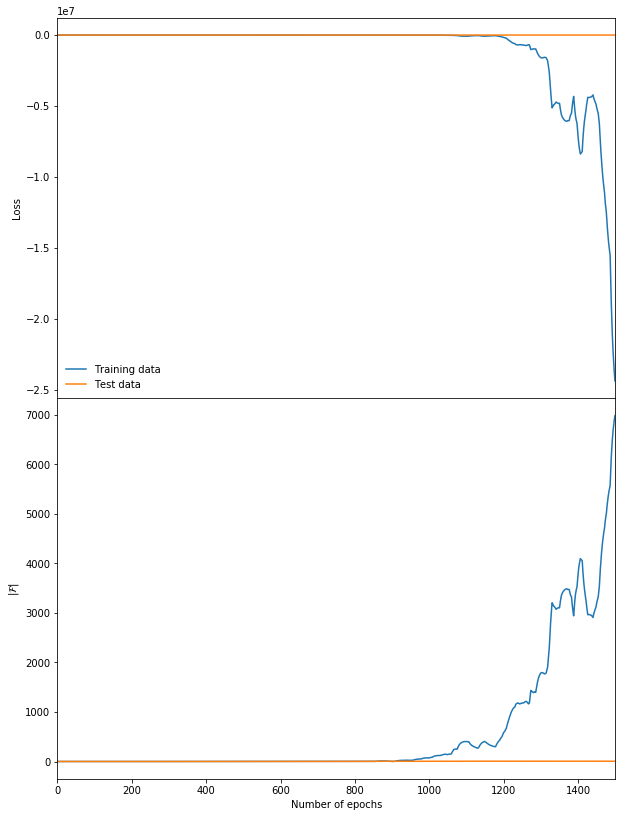

In [18]:
train_F = np.array(train_F)
test_F = np.array(test_F)
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (10, 14))
plt.subplots_adjust(hspace = 0)
end = len(train_F)
epochs = np.arange(end)
a, = ax[0].plot(epochs, -0.5 * train_F[:end]**2, label = 'Training data')
b, = ax[0].plot(epochs, -test_F[:end]**2, label = 'Test data')
ax[0].legend(frameon = False)
ax[0].set_ylabel('Loss')
ax[1].plot(epochs, train_F[:end])
ax[1].plot(epochs, test_F[:end])
ax[1].set_ylabel('$|\mathcal{F}|$')
ax[1].set_xlabel('Number of epochs')
ax[1].set_xlim([0, len(epochs)]);

We can see that the test loss deviates from the training loss. This is to be expected because there are will be a lot of correlation within a small training set which isn't in the test set. As long as the test loss doesn't start increasing then it is likely that the network is still working, with the maximum Fisher available being the value obtained from the test set.

## Resetting the network
If you need to reset the weights and biases for any reason then you can call
```python
n.reinitialise_session()
```

## Saving the network

If you don't initialise the network with a save name you can save the network as a `TensorFlow` `meta` graph. For example saving the model in the directory `/.data` called `saved_model.meta` can be done using the function
```python
n.save_network(file_name = "data/saved_model", first_time = True)
```
If `save file` is passed with a correct file name when initialising the module then the initialised network will be saved by
```python
n.begin_session()
```
and then saved at the end of training.

## Loading the network

You can load the network from a `TensorFlow` `meta` graph (from `/.data/saved_model.meta`) using
```python
parameters = {
    'verbose': True,
    'number of simulations': 500,
    'differentiation fraction': .1,
    'number of parameters': 1,
    'number of summaries': 1,
    'input shape': [10, 20, 1],
    'prebuild': False,
    'save file': "data/saved_model",
}
```
and then running
```python
n = IMNN.IMNN(parameters = parameters)
n.restore_network()
```
Training can be continued after restoring the model - although the Adam optimiser might need to reacquaint itself.

## Approximate Bayesian computation
We can now do ABC (or PMC-ABC) with our calculated summary. First we generate some simulated real data:

In [19]:
real_data = generate_data(θ = [1.], train = False)

We can plot this real data to see what it looks like.

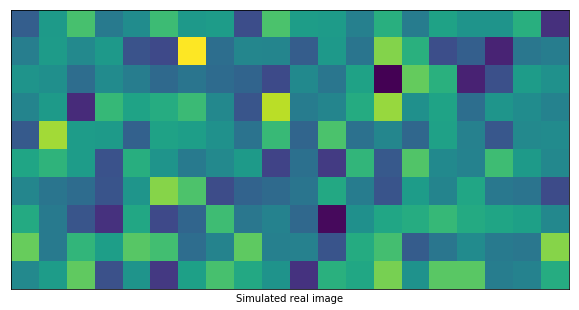

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (10, 12))
ax.imshow(real_data[0, :, :, 0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Simulated real image');

### Calculate Fisher information matrix
We calculate the Fisher information matrix by running the test data through the network. We need to shuffle and get a combination of the data before feeding it through the graph so that it has the correct shape.

In [21]:
#ttd = n.shuffle(data = test_data[0], data_m = test_data[1], data_p = test_data[2], n_train = 1)
#tt, tt_m, tt_p = n.get_combination_data(data = ttd, combination = 0, n_batches = 1)
#F = n.sess.run(n.F, feed_dict = {n.x: tt, n.x_m: tt_m, n.x_p: tt_p, n.dropout: 1., n.dd: der_den})
F = n.sess.run(n.test_F, feed_dict = {n.dd: der_den})

### ABC
We now perform ABC by drawing 100000 random samples from the prior. We define the upper and lower bounds of a uniform prior to be 0 and 10. Only a uniform prior is implemented at the moment. From the samples we create simulations at each parameter value and feed each simulation through the network to get summaries. The summaries are compared to the summary of the real data to find the distances which can be used to accept or reject points.
Because the simulations are created within the ABC function then the generation function must be passed. This is why the generator should be of the form defined above, which takes only a list of parameter values and returns a simulation at each parameter.

In [22]:
θ, summary, s, ρ = n.ABC(real_data = real_data, F = F, prior = [0, 10], draws = 100000, generate_simulation = generate_data, at_once = True)

If the simulations are going to be too large to make all at once the `at_once` option can be set to false which will create one simulation at a time.
```python
θ, summary, s, ρ = n.ABC(real_data = real_data, F = F, prior = [0, 10], draws = 100000, generate_simulation = generate_data, at_once = False)
```

### Accept or reject
In ABC draws are accepted if the distance between the simulation summary and the simulation of the real data are "close", i.e. smaller than some ϵ value, which is chosen somewhat arbitrarily.

In [23]:
ϵ = 5
accept_indices = np.argwhere(ρ < ϵ)[:, 0]
reject_indices = np.argwhere(ρ >= ϵ)[:, 0]

### Plot samples
We can plot the output samples and the histogram of the accepted samples, which should peak around `θ = 1`. The monotonic function of all the output samples shows that the network has learned how to summarise the data.

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


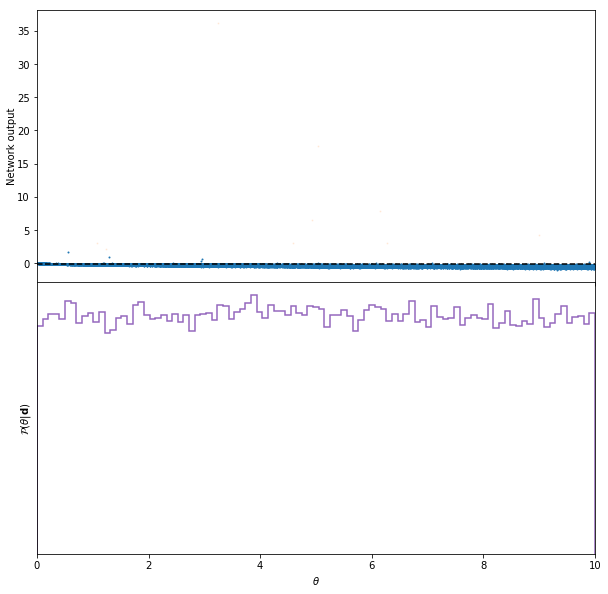

In [24]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (10, 10))
plt.subplots_adjust(hspace = 0)
ax[0].scatter(θ[accept_indices] , s[accept_indices, 0], s = 1)
ax[0].scatter(θ[reject_indices], s[reject_indices, 0], s = 1, alpha = 0.1)
ax[0].plot([0, 10], [summary[0], summary[0]], color = 'black', linestyle = 'dashed')
ax[0].set_ylabel('Network output', labelpad = 0)
ax[0].set_xlim([0, 10])
ax[1].hist(θ[accept_indices], np.linspace(0, 10, 100), histtype = u'step', normed = True, linewidth = 1.5, color = '#9467bd');
ax[1].set_xlabel('$\\theta$')
ax[1].set_ylabel('$\\mathcal{P}(\\theta|{\\bf d})$')
ax[1].set_yticks([]);

There can be a lot of $\theta$ draws which are unconstrained by the network because no similar structures were seen in the data which is indicative of using too small of a small training set.

## PMC-ABC
Population Monte Carlo ABC is a way of reducing the number of draws by first sampling from a prior, accepting the closest 75% of the samples and weighting all the rest of the samples to create a new proposal distribution. The furthest 25% of the original samples are redrawn from the new proposal distribution. The furthest 25% of the simulation summaries are continually rejected and the proposal distribution updated until the number of draws needed accept all the 25% of the samples is much greater than this number of samples. This ratio is called the criterion. The inputs work in a very similar way to the `ABC` function above. If we want 1000 samples from the approximate distribution at the end of the PMC we need to set `num_keep = 1000`. The initial random draw (as in ABC above) initialises with `num_draws`, the larger this is the better proposal distribution will be on the first iteration.

In [25]:
θ_, summary_, ρ_, s_, W, total_draws = n.PMC(real_data = real_data, F = F, prior = [0, 10], num_draws = 1000, num_keep = 1000, generate_simulation = generate_data, criterion = 0.05, at_once = True, samples = None)

If we want the PMC to continue for longer we can provide the output of PMC as an input as
```python
θ_, summary_, ρ_, s_, W, total_draws = n.PMC(real_data = real_data, F = F, prior = [0, 10], num_draws = 1000, num_keep = 1000, generate_simulation = generate_data, criterion = 0.001, at_once = True, samples = [θ_, summary_, ρ_, s_, W, total_draws])
```
Finally we can plot the accepted samples and plot their histogram.

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


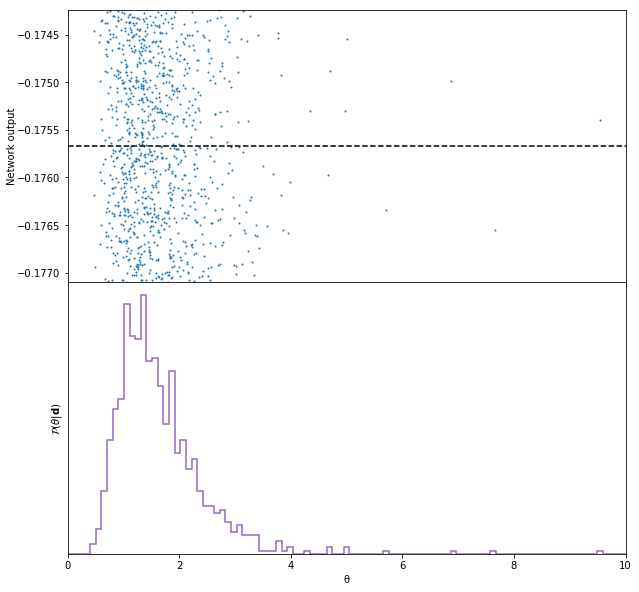

In [26]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (10, 10))
plt.subplots_adjust(hspace = 0)
ax[0].scatter(θ_ , s_, s = 1)
ax[0].plot([0, 10], [summary[0], summary[0]], color = 'black', linestyle = 'dashed')
ax[0].set_ylabel('Network output', labelpad = 0)
ax[0].set_xlim([0, 10])
ax[0].set_ylim([np.min(s_), np.max(s_)])
ax[1].hist(θ_, np.linspace(0, 10, 100), histtype = u'step', normed = True, linewidth = 1.5, color = '#9467bd');
ax[1].set_xlabel('θ')
ax[1].set_ylabel('$\\mathcal{P}(\\theta|{\\bf d})$')
ax[1].set_yticks([]);

We don't suffer from the unseen samples as much using the PMC because within a smaller $\epsilon$ there are fewer of these unknown draws.